# Masking and second order DPA

You need:
* `plaintext.txt`: all PT blocks, (one block per line, in hex, bytes separated by spaces)
* `ciphertext.txt`: all CT blocks, (one block per line, in hex, bytes separated by spaces)
* `traceLength.txt`: how many samples per trace (one decimal number)
* `traces.bin`: raw measured traces, one byte per sample (uint8), all traces together continuously
Original: https://colab.research.google.com/gist/bucekj/8c913671f00d4ee2ac59649cbd6b9b7b#scrollTo=8fW8nPQ5uyEO 

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# AES SBOX
sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
    ], dtype='uint8')

# Hamming weight lookup table
hw_table = []
for i in range(256):
    s = '{0:08b}'.format(i)
    hw_table.append(s.count('1'))
hw_table = np.array(hw_table, 'uint8')

# Correlation of two matrices
def correlate(x, y):
    """
    Correlate all columns from matrix x of shape (a,b)
    with all columns from matrix y of shape (a,c),
    creating correlation matrix C of shape (b,c).
    
    Originally matlab script by Jiri Bucek in NI-HWB.
    """
    x = x - np.average(x, 0) # remove vertical averages
    y = y - np.average(y, 0) # remove vertical averages
    C = x.T @ y              # (n-1) Cov(x,y)
    C = C / (np.sum(x**2, 0)**(1/2))[:,np.newaxis] # divide by (n-1) Var(x)
    C = C / (np.sum(y**2, 0)**(1/2))               # divide by (n-1) Var(y)
    return C

# Load PT of CT from file
def load_text(file_name):
    """
    Load any text PT/CT from file containing hex strings with bytes 
    separated by spaces, one block per line
    Output is a matrix of bytes (np.array)
    """
    txt_str = open(file_name).readlines()
    # del txt_str[-1] #discard last empty line
    #split each line into bytes and convert from hex
    txt_bytes_list = list(
        map(lambda line: 
                list(
                    map(lambda s: int(s, 16),
                        line.rstrip().split(" "))
                ),
            txt_str)
        )
    return np.array(txt_bytes_list, 'uint8')

# read plaintext inputs
inputs = load_text("measurement/plaintext.txt")

# read length of one complete trace (number of samples per trace)
with open("measurement/traceLength.txt", "r") as fin:
  trace_length = int(fin.readline())

# trim each trace - select interesting part
# start = 704400
# len = 704400+20000
start = 0
len = trace_length 

# read traces from binary file
traces = np.fromfile("measurement/traces.bin", dtype='uint8') # read as linear array
traces = np.reshape(traces, (traces.size // trace_length, trace_length)) # reshape into matrix
traces = traces[:, start:len] # select only the interesting part of each trace

print(inputs.shape) # dimensions of inputs
print(trace_length)
print(traces.shape) # dimensions of matrix of traces
n_input = inputs.shape[0]

# If you feel brave enough -- interactive plots
#!pip install ipympl
#from google.colab import output
#output.enable_custom_widget_manager()
%matplotlib widget

(1000, 16)
1562500
(1000, 1562500)


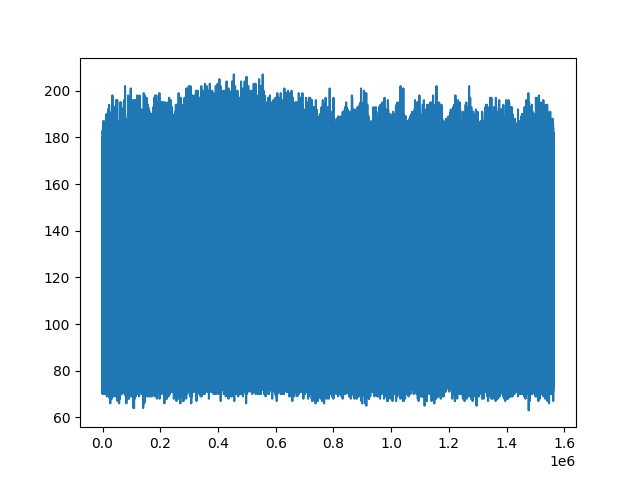

In [7]:
# Plot one trace
fig = plt.figure()
plt.plot(traces[1])
plt.show()

### Normal DPA attack

In [8]:
from Crypto.Cipher import AES
%matplotlib widget

ciphertext = load_text("measurement/ciphertext.txt")
plaintextBlock = bytes(inputs[0])
ciphertextBlock = bytes(ciphertext[0])

def test_key(kk):
    key_bytes = bytes(kk)
    cipher = AES.new(key_bytes, AES.MODE_ECB)

    # Encrypting the plaintext using the cipher object
    encrypted_plaintext = cipher.encrypt(plaintextBlock)

    # Verifing that the encrypted plaintext matches the given ciphertext
    if encrypted_plaintext == ciphertextBlock:
        print("The key is valid !")
    else:
        print("Invalid key :(")

def display_correlation(corr, k):
    if k > 0  and k < 255:
        fig = plt.figure()
        plt.plot(corr[k+1])
        plt.plot(corr[k-1])
        plt.plot(corr[k])
        plt.show()
    else:
        print("k out of range for ploting")

- Discover the secret key (with hamming wieght power model)

In [9]:
keys = np.array(range(0, 256))
kk = np.zeros(16, dtype='uint8')
for i in range(0, 16):
    inp = inputs[:, i]
    # XOR each data byte with each key
    xmat = inp[:, np.newaxis] ^ keys
    # Substitute with SBOX all XORed values -- matrix of intermediate values
    smat = sbox[xmat]
    # Compute Hamming Weights -- the matrix of hypothetical power consumption
    hmat = hw_table[smat]
    # Find correlation between hamming weights and traces
    corr = correlate(hmat, traces[0:n_input,800000:850000])
    # Display first key byte correlation trace
    acorr = abs(corr)
    # Find the most correlated key and store it in the corr_table
    max_acorr = acorr.max()
    (k, j) = np.where(acorr == max_acorr) # find indices of maximum
    kk[i] = k
    print("%1c, %02x @ %d" % (k[0], k[0], j[0]))
test_key(kk)
correct_key = kk

÷, f7 @ 13259
W, 57 @ 8132

, 0a @ 22204
j, 6a @ 17729
9, 39 @ 10133
p, 70 @ 5664
), 29 @ 1258
÷, f7 @ 17321
, 14 @ 40913
ø, f8 @ 22889
y, 79 @ 22537
Ñ, d1 @ 25249
ø, f8 @ 34319
, 16 @ 46118
f, 66 @ 19106
þ, fe @ 3818
Invalid key :(


Find the first round by correlation with the plaintext. You should see a series of peaks right after the trigger, and then again after a few milliseconds. This is where the first round starts.

600000 - 630000


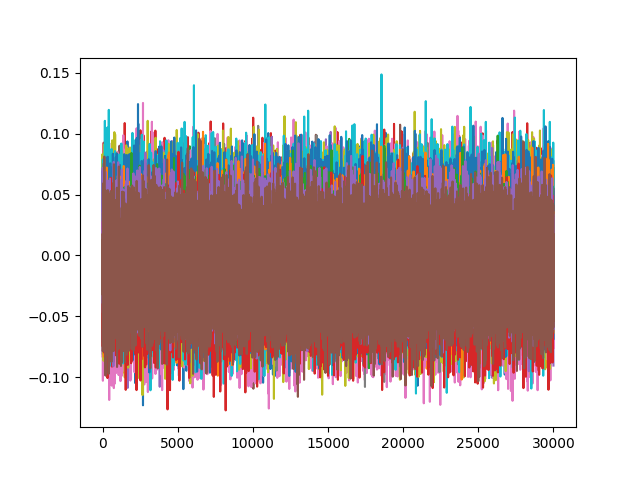

630000 - 660000


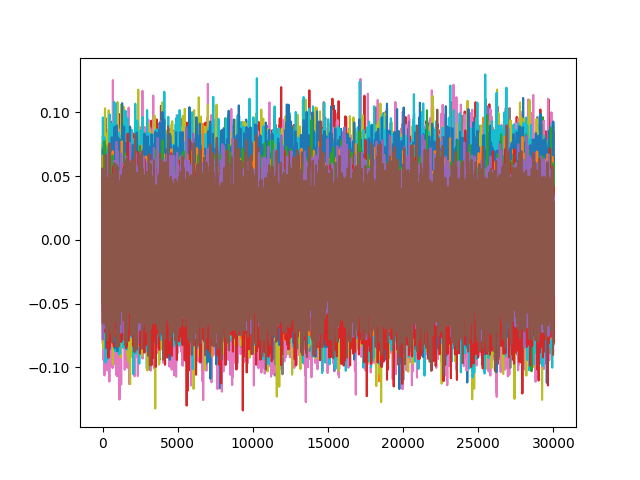

660000 - 690000


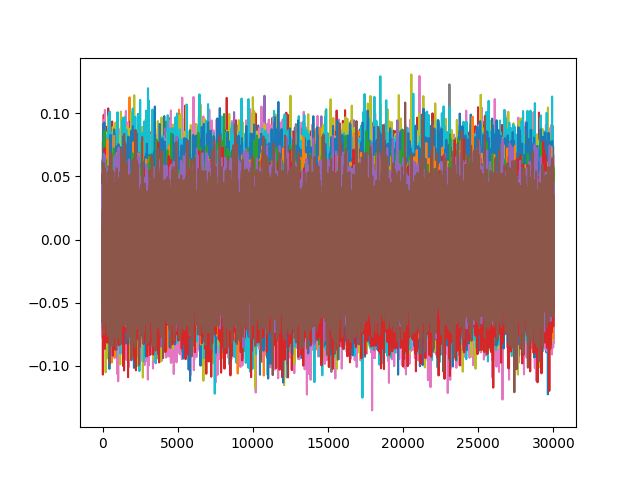

690000 - 720000


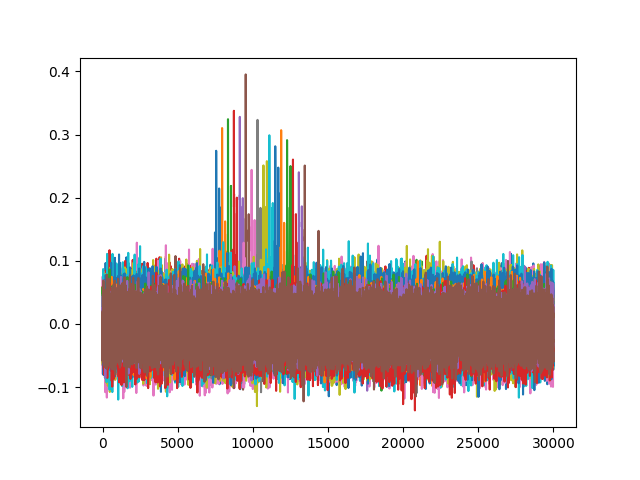

In [10]:
hmat = hw_table[inputs]
for i in range(20,24):
    print(f"{30000*i} - {30000+i*30000}")
    corr = correlate(hmat, traces[:,30000*i:30000+i*30000])
    fig = plt.figure()
    plt.plot(corr.T)
    plt.show()

With cross-correlation, we found plaintext processing of the traces (697410:704400). We now that the mask computation should be right after, thus we select the 30k traces after the last "peak". We can now compress this part of the traces.

In [12]:
t = traces[:,704400:704400+20000].reshape([1000,4000,5]).mean(axis=2, dtype=np.float32)
# t = traces.reshape([1000,4000,5]).mean(axis=2, dtype=np.float32)
t.shape

(1000, 4000)

Pre-processing
- use absolute difference as pre() function: `np.abs(y-x)`

In [13]:
l = t.shape[1]
d = 50
T_tilda = np.zeros([t.shape[0],(l-d)*d], dtype=np.float32)

for i in range(l-d):
    absolute_diff = np.abs(t[:,i:i+1] - t[:,i+1:i+1+d])
    T_tilda[:,i*d:i*d+d] = absolute_diff
T_tilda

array([[30.40001 , 28.600006, 31.40001 , ..., 23.799995, 28.999992,
        44.59999 ],
       [28.399994, 34.399994, 32.199997, ..., 35.600006, 30.40001 ,
        48.800003],
       [30.600006, 34.200005, 31.800003, ..., 42.59999 , 28.999992,
        47.799995],
       ...,
       [27.40001 , 54.      , 36.600006, ..., 36.200005, 10.200005,
        27.000008],
       [24.199997, 60.6     , 48.6     , ..., 44.      , 26.400002,
        37.199997],
       [31.399994, 64.4     , 47.800003, ..., 43.600006, 18.600006,
        37.      ]], dtype=float32)

Let's break the CT

NameError: name 'traces' is not defined